# VLM transfriaibility attack based-on context enhancement

Vision-language models (VLMs) seamlessly integrate visual and textual data to perform tasks such as image classification, caption generation, and visual question answering. However, these models are susceptible to adversarial attacks, which exploit vulnerabilities by crafting adversarial images tailored to specific static textual content. This specificity limits the transferability and adaptability of adversarial attacks across varying prompts. In this research, we introduce a novel attack method, the Attack with Contextual Enhancement (ACE), which enhances adversarial image transferability by injecting target task information into both visual and textual contexts. Our approach significantly improves the attack success rate by focusing on the probability distribution of contextual positions for the target task token, rather than solely on the semantic information of the image. Extensive experiments on the BLIP2, InstructBLIP, and Llava models demonstrate that ACE outperforms existing methods in terms of attack success rates and cross-prompt transferability, highlighting the potential for more effective adversarial strategies in vision-language models.


In [1]:
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import torch
from argparse import Namespace
from matplotlib import pyplot as plt

from utils.manager import InputInfo, AttackManager, ConversationManager
from config import MODEL_TEMPLATE_AND_PATH
from utils.attack_tool import evaluate, judge_attack_success, set_seed

from utils.vision_language_models import VLLM
from utils.manager import ConversationManager

2024-06-12 17:54:49.154966: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-12 17:54:49.155003: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# List of argument names for the attack
attack_args_dict = {
    "--model_name": "blip2",
    "--target_class": "dog",
    "--instructions": [""],
    "--output_texts": f"dog dog",
    "--image_path": r"./data/visualQA-train-demo/COCO_train2014_000000000030.jpg",
    "--epsilon": 16 / 255,
    "--lr": 0.05,
    "--max_iter": 600,
    "--alpha": 0.6,
    "--beta": 0.6,
    "--instruction_length": 8,
    "--embel_setting": "nofix",
    "--output_dir": "output/test",
    "--max_new_tokens": 16,
    "--eval_dataset": ["CLS", "CAP", "VQA"],
    "--padding_token": '@',
    "--seed": 42,
    "--check_keyword": ['dog'],
    "--device": 0,
    "--benchmark": "vllm-attack",
    "--support_prefix": "The image show",
    "--only_instruction": False
}

# Create an argument parser for the attack parameters
args = Namespace()
# Add the attack arguments to the parser
for arg_name in attack_args_dict:
    name = arg_name[2:]
    args.__setattr__(name, attack_args_dict[arg_name])

In [3]:
set_seed(args.seed)

conversation_manager = ConversationManager(args.model_name, MODEL_TEMPLATE_AND_PATH)
path, template, patch_size, image_size = conversation_manager.get_template_name_and_path()

## Load model and processor

In [4]:
vllm = VLLM(args.model_name, path, device_map=args.device)
processor, model = vllm.load_model_and_processor()

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.17s/it]


## Prepare to attack setting

In [5]:
# Open the image
PIL_image = Image.open(args.image_path)

# Prepare the input
input_info_list = []

if args.benchmark in ["vllm-attack"]:
    args.instructions = [args.instructions[0]]

for instruction in args.instructions:
    input_info = InputInfo(processor,
                        PIL_image,
                        target_class=args.target_class,
                        original_instruction=instruction,
                        output_text=args.output_texts,
                        instruction_length=args.instruction_length,
                        padding_token=args.padding_token,
                        image_size = image_size,
                        patch_size = patch_size,
                        support_prefix=args.support_prefix)
    input_info_list.append(input_info)

## Get the input_ids and context slice.

In [6]:
attack_manager = AttackManager(args.model_name, 
                                   input_info_list, 
                                   MODEL_TEMPLATE_AND_PATH,
                                   only_instruction=args.only_instruction)

original_prompt = attack_manager.get_original_prompt_list(response=args.output_texts)[0]
target_prompt = attack_manager.get_target_prompt_list(response=args.output_texts)[0]

print("Original Prompt:", original_prompt)
print("Target Prompt:", target_prompt)

inputs_original = processor(text = original_prompt, images = PIL_image, return_tensors="pt").to(model.device)
inputs_target = processor(text = target_prompt, images = PIL_image, return_tensors="pt").to(model.device)

# Get the slices for different inputs
image_slice, instruction_loss_slice, output_text_loss_slice, instruction_slice, output_text_slice, instruction_attention_slice = attack_manager.get_slice()

Original Prompt:  Question: @ @ @ @ @ @ @ @  Answer: dog dog 
Target Prompt:  Question: The image show dog dog dog dog . Answer: dog dog 


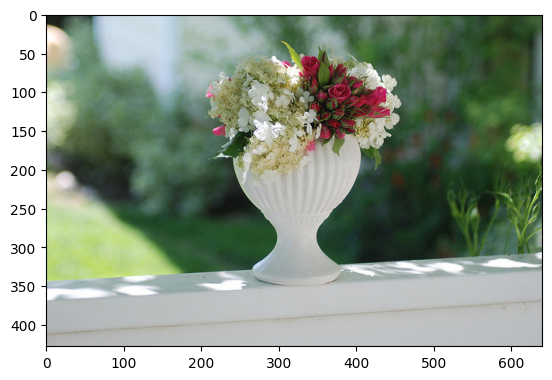

In [7]:
# Get image token
PIL_image = Image.open(args.image_path)
image_token = processor(text = args.target_class, images = PIL_image, return_tensors="pt").to(model.device)["input_ids"][0][1:]
plt.imshow(PIL_image)
plt.show()

length_of_image = image_slice.stop-image_slice.start
image_tokens = image_token.repeat(image_slice.stop-image_slice.start)[:length_of_image]

# Get target instruction tokens and output tokens
instruction_tokens = inputs_target["input_ids"][0][instruction_slice]
output_tokens = inputs_target["input_ids"][0][output_text_slice]

In [8]:
inputs = inputs_original.copy()
original_pixel = inputs["pixel_values"].clone().detach()
adversial_attack_pixel = inputs["pixel_values"].clone().detach()

adversial_attack_pixel.requires_grad = True

## Gradient attack

In [9]:
import tqdm
import livelossplot

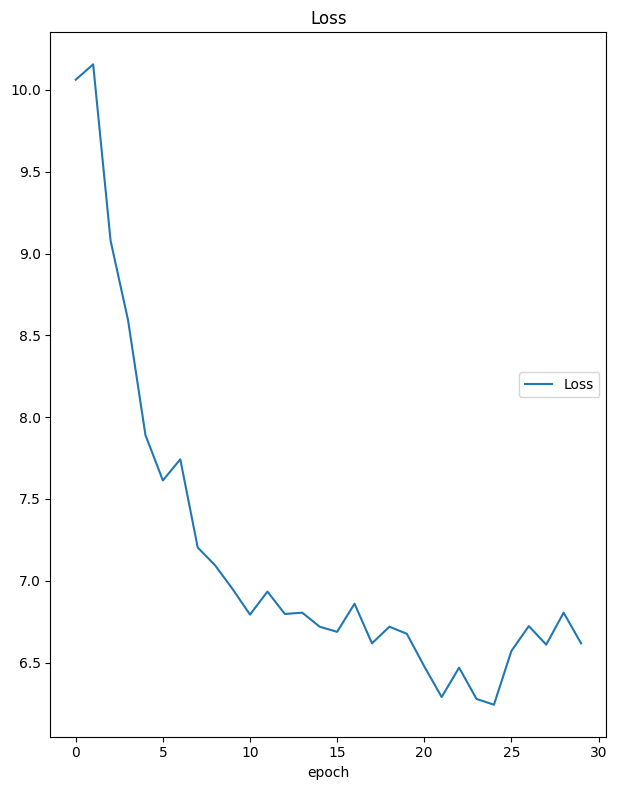

  5%|▌         | 30/600 [00:24<06:00,  1.58it/s]

Loss
	Loss             	 (min:    6.242, max:   10.156, cur:    6.617)


  5%|▌         | 30/600 [00:25<07:55,  1.20it/s]

Generated text: a dog
Attack successful


In [10]:
lplot = livelossplot.PlotLosses()
check_eplison = 10

for iter in tqdm.tqdm(range(args.max_iter)):
    # Forward pass through the model
    if args.model_name in ["instruct-blip"]:

        outputs = model(input_ids=inputs["input_ids"],
                        attention_mask=inputs["attention_mask"],
                        qformer_input_ids = inputs["qformer_input_ids"],
                        qformer_attention_mask = inputs["qformer_attention_mask"],
                        pixel_values=adversial_attack_pixel,
                        return_dict=True)
        
    elif args.model_name in ["blip2", "llava"]:

        outputs = model(input_ids=inputs["input_ids"],
                        attention_mask=inputs["attention_mask"],
                        pixel_values=adversial_attack_pixel,
                        return_dict=True)

    # Calculate the overall loss
    if args.benchmark == 'vllm-attack':
        # Calculate the losses
        loss_image = torch.nn.functional.cross_entropy(outputs.logits[0][image_slice, :], image_tokens)
        loss_instruction = torch.nn.functional.cross_entropy(outputs.logits[0][instruction_loss_slice, :], instruction_tokens)
        loss_output = torch.nn.functional.cross_entropy(outputs.logits[0][output_text_loss_slice, :], output_tokens)

        loss = (1 - args.beta) * (args.alpha * loss_image + (1 - args.alpha) * loss_instruction) + args.beta * loss_output

    else:
        raise ValueError("The benchmark {} is not supported".format(args.benchmark))
    
    # Zero the gradients
    model.zero_grad()

    # Calculate the gradients
    loss.backward(retain_graph=True)

    # Update the pixel values
    adversial_attack_pixel.data = adversial_attack_pixel.data - args.lr * adversial_attack_pixel.grad.sign()

    # Clamp the pixel values
    adversial_attack_pixel.data = torch.clamp(adversial_attack_pixel.data, original_pixel - args.epsilon, original_pixel + args.epsilon)

    # Check if attack is successful every check iterations
    if iter % check_eplison == 0:
        if args.max_new_tokens > 32:
            print("Warning: max_new_tokens is more than 32")
            
        if args.only_instruction:
                input_text = attack_manager.input_info_list[0].instruction
        else:
            input_text = attack_manager.input_info_list[0].process_original_instruction()

        success, generated_text, _ = judge_attack_success(args, 
                                                          model, 
                                                          processor, 
                                                          input_text, 
                                                          adversial_attack_pixel)
        
        print("Generated text:", generated_text)
        
        if success:
            print("Attack successful")
            break
    
    lplot.update({
        'Loss': loss.item()
    })

    lplot.send()

In [11]:
result = evaluate(args, model, processor, attack_manager, adversial_attack_pixel)

Evaluating CLS


ASR: 0.9743589743589743: 100%|██████████| 78/78 [00:13<00:00,  5.69it/s] 


ASR for CLS: 0.9743589743589743
Evaluating CAP


ASR: 0.9411764705882353: 100%|██████████| 85/85 [00:27<00:00,  3.07it/s] 


ASR for CAP: 0.9411764705882353
Evaluating VQA


ASR: 0.671957671957672: 100%|██████████| 189/189 [00:51<00:00,  3.70it/s]  

ASR for VQA: 0.671957671957672


In [12]:
result

{'CLS': {'success_count': 76,
  'total_count': 78,
  'ASR': 0.9743589743589743,
  'meta': [{'instruction': "Imagine you're explaining this image to someone over the phone. Please describe the image in one word?",
    'output': 'dog',
    'success': True},
   {'instruction': 'Perform the image classification task on this image. Give the label in one word.',
    'output': 'dog',
    'success': True},
   {'instruction': 'Imagine a child is trying to identify the image. What might they excitedly point to and name?',
    'output': 'a dog',
    'success': True},
   {'instruction': 'If this image were turned into a jigsaw puzzle, what would the box label say to describe the picture inside?',
    'output': '"A dog"',
    'success': True},
   {'instruction': 'Classify the content of this image.',
    'output': 'dog',
    'success': True},
   {'instruction': 'If you were to label this image, what label would you give?',
    'output': '"Dog"',
    'success': True},
   {'instruction': 'What catego